[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Piphi5/Adopt-a-Pixel3km-Notebooks/blob/main/Geospatial%20Enrichment/PSU%20Enrichment.ipynb)

# Setup

In [1]:
import os
import sys
from collections import Counter

import ee
import numpy as np
import pandas as pd
import requests

if "google.colab" in sys.modules:
    ee.Authenticate()
    ee.Initialize()
elif "GITHUB_JOB" in os.environ and os.environ["GITHUB_JOB"].startswith("ee-test"):
    import json

    credentials_json = "../ee-credentials.json"

    if os.path.exists(credentials_json):
        with open(credentials_json) as f:
            data = json.load(f)
        service_account = data["client_email"]
        credentials = ee.ServiceAccountCredentials(service_account, credentials_json)
        ee.Initialize(credentials)
else:
    ee.Initialize()

files = [
    "aoi_grid_utils",
    "combine_csvs",
    "harmonization_utils",
    "ee_utils",
    "plotting_utils",
]

if "google.colab" in sys.modules or (
    "GITHUB_JOB" in os.environ and os.environ["GITHUB_JOB"] == "colab-test"
):
    for file in files:
        url = f"https://raw.githubusercontent.com/Piphi5/Adopt-a-Pixel3km-Notebooks/main/utils/code/{file}.py"
        exec(requests.get(url).text)
else:
    module_path = os.path.abspath(os.path.join("../utils/code"))
    sys.path.append(module_path)
    from aoi_grid_utils import *
    from combine_csvs import *
    from ee_utils import *
    from harmonization_utils import *
    from plotting_utils import *

# Get CEO Plot Data

`psu_path`: Path to the PSU CSV
`output_path`: Path to folder storing outputs

In [2]:
psu_path = "PSU Sample Data/PSU Data.csv"
output_path = "PSU Sample Output"

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [3]:
ceo_df = pd.read_csv(psu_path)

# Harmonizes CEO data if it hasn't already been harmonized
if not any(
    [
        ceo_col in col
        for ceo_col in harmonized_ceo_legend.keys()
        for col in ceo_df.columns
    ]
):
    ceo_harmonization(ceo_df)

ceo_df

,Unnamed: 0,plot_id,center_lon,center_lat,size_m,shape,sample_points,email,flagged,flagged_reason,...,Land Cover Elements:Building,Land Cover Elements:Impervious Surface (no building),AOI Number,CEO_BuiltUp,CEO_Trees,CEO_Shrubland,CEO_Grassland,CEO_Cropland,CEO_Water,CEO_Barren
0,0,140877071,-89.568191,43.076827,square,100.0,100,52,False,NaN,...,0.0,0.0,0.0,0.0,19.0,14.0,60.0,0.0,0.0,7.0
1,2058,140879129,-96.732731,33.127087,square,100.0,100,66,False,NaN,...,8.0,66.0,55.0,74.0,13.0,0.0,13.0,0.0,0.0,0.0
2,2056,140879127,-96.743470,33.127087,square,100.0,100,66,False,NaN,...,24.0,31.0,55.0,55.0,5.0,0.0,40.0,0.0,0.0,0.0
3,2055,140879126,-96.748839,33.127087,square,100.0,100,66,False,NaN,...,20.0,34.0,55.0,54.0,16.0,2.0,28.0,0.0,0.0,0.0
4,2054,140879125,-96.754209,33.127087,square,100.0,100,66,False,NaN,...,29.0,33.0,55.0,62.0,2.0,0.0,35.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,704,140963199,-106.233694,31.717792,square,100.0,100,45,False,NaN,...,41.0,0.0,76.0,41.0,0.0,2.0,0.0,0.0,0.0,57.0
1994,734,140963229,-106.233694,31.695308,square,100.0,100,45,False,NaN,...,30.0,20.0,76.0,50.0,0.0,0.0,0.0,0.0,16.0,16.0
1995,716,140963211,-106.233694,31.708798,square,100.0,100,45,False,NaN,...,39.0,56.0,76.0,95.0,5.0,0.0,0.0,0.0,0.0,0.0
1996,719,140963214,-106.217837,31.708798,square,100.0,100,45,False,NaN,...,36.0,16.0,76.0,52.0,0.0,0.0,0.0,0.0,0.0,48.0


# Earth Engine Enrichment

## Specify Parameters

- `ee_layer`: Specifies layer that will be used
- `increment`: Specifies the number of points per Earth Engine job so that the request doesn't time out

In [4]:
ee_layer = "ESA/WorldCover/v100"
increment = 5000

## Generate SSU Units for Earth Engine

SSUs are needed to create percentage summaries

In [5]:
def generate_coords(center_lat, center_lon, plotid):
    coords = []
    corner_lat_offset, corner_lon_offset = get_latlon_spacing_constants(45, center_lat)
    latitude_const, longitude_const = get_latlon_spacing_constants(10, center_lat)
    top_left_lat = center_lat + corner_lat_offset
    top_left_lon = center_lon + corner_lon_offset

    for i in range(10):
        for j in range(10):
            latitude = top_left_lat - i * latitude_const
            longitude = top_left_lon + j * longitude_const
            coords.append((latitude, longitude, plotid))
    return coords


def generate_ee_grid(latitudes, longitudes, plotids):
    ee_objs = []
    for psu in zip(latitudes, longitudes, plotids):
        ee_objs.extend(generate_coords(*psu))

    return [
        ee.Feature(ee.Geometry.Point([point[1], point[0]]), {"plot_id": int(point[2])})
        for point in ee_objs
    ]


ceo_features = generate_ee_grid(
    ceo_df["center_lat"], ceo_df["center_lon"], ceo_df["pl_plotid"]
)

In [6]:
dataset = ee.ImageCollection(ee_layer).first()

In [9]:
tasks = download_ee_points(dataset, ceo_features, increment, "CEO WC Data", "CEOWC")

In [10]:
print_job_statuses(tasks)

{'COMPLETED': 13, 'READY': 27}


# Combining GEE Data

`wc_directory`: The directory containing the Earth Engine Data that should have been downloaded to your drive

In [7]:
wc_directory = "PSU World Cover Data"

## Combine, Merge, and Harmonize GEE and CEO

In [8]:
wc_ceo_df = get_csvs(wc_directory)
wc_ceo_df

,system:index,median,plot_id,.geo
0,0,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56763695652..."
1,1,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56751383574..."
2,2,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56739071497..."
3,3,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56726759420..."
4,4,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56714447342..."
...,...,...,...,...
4995,4995,10.0,8313,"{""type"":""Point"",""coordinates"":[-74.10724864401..."
4996,4996,10.0,8313,"{""type"":""Point"",""coordinates"":[-74.10712960375..."
4997,4997,10.0,8313,"{""type"":""Point"",""coordinates"":[-74.10701056349..."
4998,4998,10.0,8313,"{""type"":""Point"",""coordinates"":[-74.10689152322..."


In [9]:
cols = list(wc_id_classification_map.values()) + ["pl_plotid"]
wc_ceo_percentage_df = pd.DataFrame(columns=cols)

# TODO Clean this up
for plotid, data in wc_ceo_df.groupby("plot_id"):
    classifications = worldcover_converter(data["median"].to_numpy())
    classification_counter = {
        classification: [100 * count / len(classifications)]
        for classification, count in dict(Counter(classifications.tolist())).items()
    }
    classification_counter["pl_plotid"] = plotid
    wc_ceo_percentage_df = wc_ceo_percentage_df.append(
        pd.DataFrame.from_dict(classification_counter)
    )
wc_ceo_percentage_df.fillna(0.0, inplace=True)

In [10]:
wc_ceo_percentage_df

,Trees,Shrubland,Grassland,Cropland,Built-up,Barren / Sparse Vegetation,Snow and Ice,Open Water,Herbaceous Wetland,Mangroves,Moss and Lichen,pl_plotid
0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,70.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
0,51.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
0,63.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,11332
0,73.0,0.0,0.0,0.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,11333
0,95.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,11334
0,46.0,0.0,0.0,0.0,51.0,3.0,0.0,0.0,0.0,0.0,0.0,11335


In [11]:
combined_df = ceo_df.merge(wc_ceo_percentage_df, on="pl_plotid", how="outer")
combined_df["Trees"] = combined_df["Mangroves"] + combined_df["Trees"]
combined_df

,Unnamed: 0,plot_id,center_lon,center_lat,size_m,shape,sample_points,email,flagged,flagged_reason,...,Shrubland,Grassland,Cropland,Built-up,Barren / Sparse Vegetation,Snow and Ice,Open Water,Herbaceous Wetland,Mangroves,Moss and Lichen
0,0.0,140877071.0,-89.568191,43.076827,square,100.0,100.0,52.0,False,NaN,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2058.0,140879129.0,-96.732731,33.127087,square,100.0,100.0,66.0,False,NaN,...,0.0,17.0,0.0,72.0,11.0,0.0,0.0,0.0,0.0,0.0
2,2056.0,140879127.0,-96.743470,33.127087,square,100.0,100.0,66.0,False,NaN,...,0.0,12.0,0.0,84.0,3.0,0.0,0.0,0.0,0.0,0.0
3,2055.0,140879126.0,-96.748839,33.127087,square,100.0,100.0,66.0,False,NaN,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2054.0,140879125.0,-96.754209,33.127087,square,100.0,100.0,66.0,False,NaN,...,0.0,61.0,0.0,35.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,30.0,0.0,19.0,5.0,0.0,0.0,0.0,0.0,0.0
2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,26.0,0.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0


# Visualize Data

`used_datasets`: These are the datasets to be visualized and compared against eachother. Currently must be: `"World Cover"`, `"CEO"`, or `"GLOBE"`. **Note:** you should only use GLOBE if the PSU CSV you analyzed had GLOBE data.

In [12]:
used_datasets = ["World Cover", "CEO"]

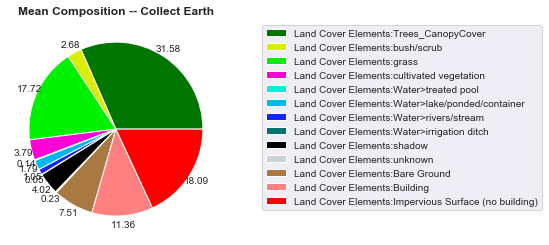

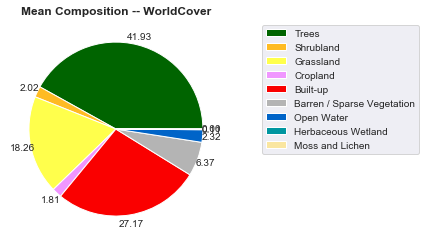

In [16]:
aoi_composition_plot(
    combined_df,
    "Collect Earth",
    [f"Land Cover Elements:{key}" for key in ceo_legend.keys()],
    ceo_legend.values(),
    directory=output_path,
)
aoi_composition_plot(
    combined_df,
    "WorldCover",
    worldcover_legend.keys(),
    worldcover_legend.values(),
    directory=output_path,
)

if "GLOBE" in used_datasets:
    aoi_composition_plot(
        combined_df,
        "GLOBE",
        go_legend.keys(),
        go_legend.values(),
        directory=output_path,
    )

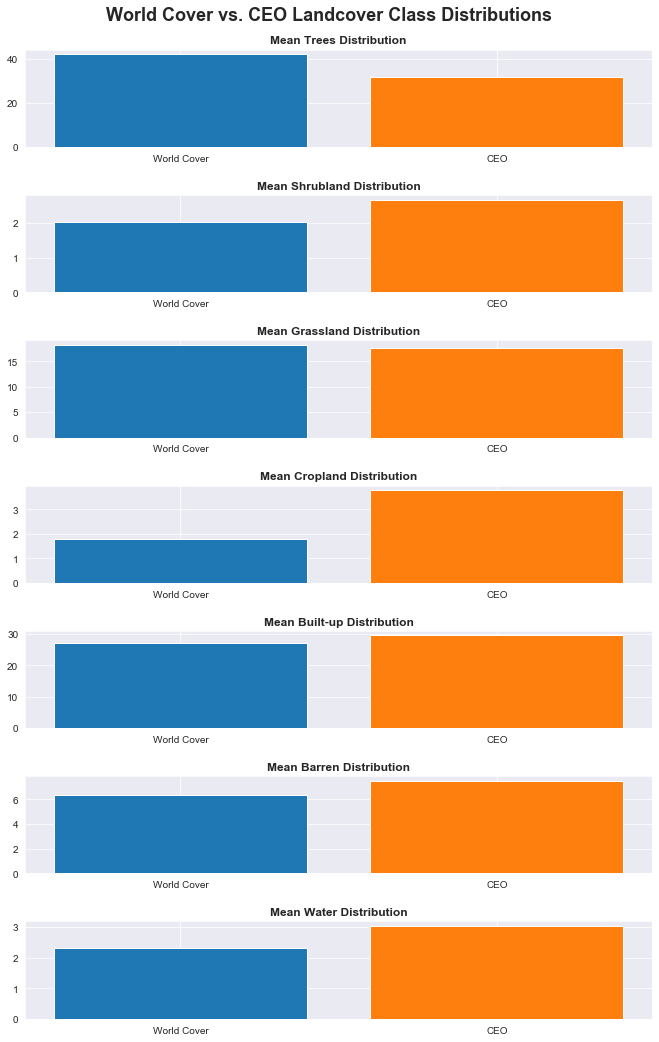

In [17]:
dataset_comparison_plot(
    combined_df,
    used_datasets,
    harmonization_table,
    harmonization_table_lookup,
    directory=output_path,
)

## Save CSV

In [18]:
combined_df.to_csv(f"{output_path}/Combined {used_datasets} PSU Data.csv")